In [1]:
import os
from google.colab import drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
home_path = '/content/gdrive/Shared drives/Embryo_data'
print(os.listdir(home_path))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['mxnet_cnn2d_embryo_58_fine_tune_data_aug_ResNet50_v2_order_random.ipynb', 'Embryo3', 'Embryo12', 'Embryo13', 'Embryo16', 'Embryo19', 'Embryo18', 'Embryo24', 'Embryo39', 'Embryo42', 'Embryo46', 'Embryo47', 'Embryo23', 'Embryo33', 'Embryo25', 'Embryo95', 'Embryo97', 'Embryo96', 'Embryo98', 'Embryo101', 'Embryo99', 'Embryo100', 'Embryo102', 'Embryo76', 'Embryo78', 'Embryo81', 'Embryo79', 'Embryo80', 'Embryo84', 'Embryo85', 'Embryo87', 'Embryo88', 'Embryo92', 'Embryo94', 'Embryo93', 'embryo_info_CS101.xlsx', 'data', 'processed', 'models', 'pix2pix_PyTorch-GAN.ipynb', 'annotation.xlsx', 'Embryo110', 'Embryo109', 'Embryo111', 'Embryo113', 'Embryo112', 'Embryo114', 'Embryo116', 'Embryo115', 'Embryo117', 'Embryo118', 'Embryo119', 'Embryo120', 'Embryo103', 'Embryo104', 'Embryo105', 'Embryo107', 'Embryo106', 'Embryo108']


In [2]:
import tensorflow as tf
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [3]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # # self.dropout = nn.Dropout(p=0.2)
        # self.batchnorm1 = nn.BatchNorm2d(20)
        # self.batchnorm2 = nn.BatchNorm2d(50)
        
        # cf comments in forward() to have step by step comments on shape progression
        # self.fc1 = nn.Linear(256 * 64 * 64, 64)
        self.fc1 = nn.Linear(100 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 512, 512)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # print(x.shape)

        # shape : 3x512x512 -> 20x512x512
        x = F.dropout(F.relu(self.conv1(x)), p=0.2, training=True)
        # x = self.batchnorm1(F.relu(self.conv1(x)))

        # x = F.relu(self.conv1(x))
        # print(x.shape)

        # 20x512x512 -> 20x256x256
        x = self.pool1(x)
        # print(x.shape)

        # 20x256x256 -> 50x256x256
        x = F.dropout(F.relu(self.conv2(x)), p=0.2, training=True)
        # x = self.batchnorm2(F.relu(self.conv2(x)))
        # x = F.relu(self.conv2(x))
        # print(x.shape)

        # 50x256x256 -> 50x128x128
        x = self.pool2(x)
        # print(x.shape)

        # 50x128x128 -> 100x128x128
        x = F.dropout(F.relu(self.conv3(x)), p=0.2, training=True)
        # print(x.shape)

        # 100x128x128 -> 100x64x64
        x = self.pool3(x)
        # print(x.shape)

        # 100x64x64 -> .
        x = x.view(-1, 100 * 64 *64)
        # print(x.shape)

        # . -> 64
        x = F.relu(self.fc1(x))
        # print(x.shape)

        # 64 -> 2
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        # print(x.shape)

        return x

In [4]:
network = SimpleConvolutionalNetwork()
name = 'torchCNN-max-windowNone-windowNone-batch20-lr0.0001-mom0.9-epoch2'
network.load_state_dict(torch.load(f'/content/gdrive/Shared drives/Embryo_data/models/best/{name}.pth'))

<All keys matched successfully>

In [5]:
network.eval()
network

SimpleConvolutionalNetwork(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=409600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [22]:
dummy_input = torch.from_numpy(np.zeros((1,3,512,512))).float()
dummy_output = network(dummy_input)
print(dummy_output)

tensor([[-0.5293, -3.0020]], grad_fn=<AddmmBackward>)


In [7]:
# Export to ONNX format
# https://towardsdatascience.com/converting-a-simple-deep-learning-model-from-pytorch-to-tensorflow-b6b353351f5d
torch.onnx.export(network, dummy_input, f'{name}.onnx', input_names=['test_input'], output_names=['test_output'])

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


In [8]:
# https://github.com/onnx/onnx-tensorflow#installation
! git clone https://github.com/onnx/onnx-tensorflow.git
! pip install -e /content/onnx-tensorflow/

fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.
Obtaining file:///content/onnx-tensorflow
  Found existing installation: onnx-tf 1.7.0
    Can't uninstall 'onnx-tf'. No files were found to uninstall.
  Running setup.py develop for onnx-tf


In [9]:
# https://github.com/onnx/onnx-tensorflow/blob/master/doc/CLI.md
!onnx-tf convert -i "torchCNN-max-windowNone-windowNone-batch20-lr0.0001-mom0.9-epoch2.onnx" -o test_model.ckpt

2020-11-26 00:15:54.169181: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-26 00:15:55,461 - onnx-tf - INFO - Start converting onnx pb to tf pb:
2020-11-26 00:15:55.700963: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-26 00:15:55.705476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-26 00:15:55.706022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-11-26 00:15:55.706064: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.

In [10]:
# https://www.tensorflow.org/guide/saved_model
model = tf.saved_model.load("test_model.ckpt")

In [19]:
model()

ValueError: ignored

In [12]:
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab/48919022
import os
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
# print(os.path.abspath('utils.py'))
import utils
help(utils)

Saving utils.py to utils.py
Help on module utils:

NAME
    utils

FUNCTIONS
    avg_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the average for that pixel across
        all images in the z-stack.
    
    get_img_at_t(t, img)
    
    get_max_pixel(embryos, data_path)
        Obtains the maximum pixel value across a set of embryos
        embryos: subset of p_embryo... train, val, test
        data_path: path from which to load processed np embryo data
    
    get_z_slice(z, img)
    
    max_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the maximum for that pixel across
        all images in the z-stack.
    
    middle_z(img)
    
    min_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the minimum for that pixel across
        all images in the z-stack.
    
    normalize(img)
        Normalizes pixel values across all images in i

In [13]:
# Fixing the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Available high quality data
embryo_inds = utils.CLEAN_IDX

# Directory of the processed *.npy files
processed_path = f'{home_path}/processed'
polar_processed_path = f'{processed_path}/polarization'

video_time_info, train_embryos, val_embryos, test_embryos = utils.split_train_test_val(home_path, embryo_inds)

z_agg_mode = "Max Z"
get_data_path = lambda data_type : f'{processed_path}/{data_type}/max'
pol_path = f'{processed_path}/polarization'

              t_num  first_anno_pol_time
embryo_index                            
3                21                   12
12              143                   11
13              143                   12
16              143                   30
18              143                   27
19              143                   32
23               40                   18
24               21                   20
25               21                   13
33               21                   15
39               21                   12
42               21                   16
46               21                   19
47               21                   17
76              109                   68
78              109                   75
79              109                   68
80              109                   65
81              109                   95
85              109                  102
87              109                   62
88              109                   75
92              

In [14]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512 # 256
IMG_HEIGHT = 512 # 256

In [15]:
def load(bf_file):
  # Load the bf_file as the input image
  input_image = tf.io.read_file(bf_file)
  input_image = tf.image.decode_png(input_image)

  # Load the corresponding fluo_file as the real image
  if type(bf_file) is str:
    fluo_file = bf_file.replace("bf_data","fluo_data")
  else:
    fluo_file = tf.strings.regex_replace(bf_file, "bf_data","fluo_data")
  real_image = tf.io.read_file(fluo_file)
  real_image = tf.image.decode_png(real_image)

  # Convert both to a float32
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  # # Obtain labels for embryo-time-polarization
  # if type(bf_file) is str:
  #     file_name = bf_file.split('/')[-1]
  #     file_name = file_name.strip(".png")
  #     labels = file_name.split('_')[1:]
  #     labels = [int(l) for l in labels]
  # else:
  #     file_name = tf.strings.split(bf_file, sep="/")
  #     print(file_name.get_shape())
  #     file_name = file_name[-1]
  #     file_name = tf.strings.strip(".png")
  #     labels = tf.strings.split(file_name, sep="_")
  #     labels = labels[1:]
  #     labels = tf.strings.to_number(labels, out_type=tf.dtypes.int32)

  return input_image, real_image, bf_file

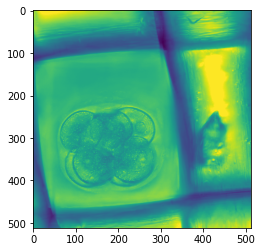

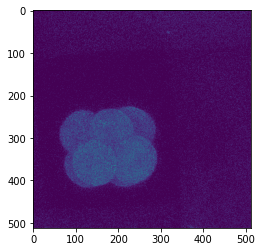

In [16]:
BF_TRAIN_PATH = f'{processed_path}/pix2pix/train/bf_data'
inp, re, _ = load(BF_TRAIN_PATH+'/embryo_3_0_0.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(tf.squeeze(inp/255.0))
plt.figure()
plt.imshow(tf.squeeze(re/255.0))

In [17]:
re

<tf.Tensor: shape=(512, 512, 1), dtype=float32, numpy=
array([[[11.],
        [11.],
        [ 0.],
        ...,
        [11.],
        [ 0.],
        [ 0.]],

       [[11.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [11.],
        [11.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [11.],
        [ 0.],
        [ 0.]],

       ...,

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [11.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [11.],
        [11.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [11.]]], dtype=float32)>

In [32]:
print(re.shape)
re_t = tf.transpose(re, (2,0,1))
print(re_t.shape)
t = tf.convert_to_tensor([re_t])
print(t.shape)

(512, 512, 1)
(1, 512, 512)
(1, 1, 512, 512)


In [33]:
model(t)

ValueError: ignored